In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # graphing
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-20 07:20:57--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-05-20 07:20:58 (1.82 MB/s) - 'names.txt' saved [228145/228145]



### Loading the Dataset

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# number of words
len(words)

32033

### Building the vocabulary

In [5]:
char = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(char)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

### Building The DataSet

In [6]:
def build_dataset(words: str, context_len: int, visualize: bool = False) -> (torch.int64, torch.int64):
    context_length = context_len # number of characters we take as input to output the next one
    X, Y = [], []
    
    for w in words:
        
        context = [0]*context_length
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            if (visualize):
                print (''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

### Train Test Split

In [7]:
def train_dev_test_split(words: list[str], context_length: int = 1,n_train: int = 0.8, n_test: int = 0.1, seed: int = 42) -> list[torch.tensor]:
    random.seed(seed)
    random.shuffle(words)
    n1 = int(n_train*len(words))
    n2 = int((n_train+n_test)*len(words))

    Xtr, Ytr = build_dataset(words[:n1], context_length)
    Xdev, Ydev = build_dataset(words[n1:n2], context_length)
    Xte, Yte = build_dataset(words[n2:], context_length)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

### Random Initialization

In [8]:
def initialize_parameters(char: list[str], embedding_size: int, context_length: int, hidden_layer_length: int = 200,seed: int = 2147483647) -> torch.tensor:
    g = torch.Generator().manual_seed(seed)
    
    vocab_length = len(char)+1
    C = torch.randn((vocab_length, embedding_size), generator = g) # embedding matrix, with size (vocab_size, embedding_size)
    W1 = torch.randn((context_length*embedding_size, hidden_layer_length), generator = g)
    b1 = torch.randn(hidden_layer_length, generator = g)
    W2 = torch.randn((hidden_layer_length, vocab_length), generator = g)
    b2 = torch.randn(vocab_length, generator = g)
    
    return C, W1, b1, W2, b2

#### Params counts

In [9]:
def params_count(parameters: list[torch.tensor]) -> int:
    return sum(p.nelement() for p in parameters) # number of params

### Optimization

In [10]:
def optimize(parameters: list[torch.tensor], Xtr: torch.tensor, Ytr: torch.tensor, num_iterations:int, var_lr: bool = False, diagnose: bool = False) -> list[torch.tensor]:
    # setting up
    C, W1, b1, W2, b2 = parameters
    for p in parameters:
        p.requires_grad = True
    
    if var_lr:
        lre = torch.linspace(-3, 0, 1000)
        lrs = 10**lre
        lri = []
    
    # printing
    if diagnose:
        lossi = []
        stepi = []
    
    for i in range(num_iterations):
    
        # minibatch contruct
        ix = torch.randint(0, Xtr.shape[0], (32,)) # takes random 32 inputs from the Xtr

        # forward pass
        # Xtr[ix] takes the ix^th index, and considers the input values, three context at that index
 
        # Thus, here, ix belongs to range(0, num_char)
        # Xtr.shape = [num_char, context_length] and outputs are in the range (vocab_length)
        # C.shape = [vocab_length, embedding size] and outputs are embeddings, which seem to be an updated version on one_hot
        # embedding.shape = [batch_size, context_length, embedding_size] and outputs are embeddings!
        emb = C[Xtr[ix]] # (32, 3, 10)
        # thus here, W1 must be [embedding_size, output_neurons]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100) for hidden_layer h
        # thus here, W2 must be [input_neurons, output_neurons]
        logits = h @ W2 + b2 # (32, 27) [batch_size, vocab_length]
        loss = F.cross_entropy(logits, Ytr[ix])
        # print(loss.item())
    
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        if (i%(num_iterations*0.1) == 0):
            print(f"===============\nepoch = {i}\n===============")
    
        # update
        # lr = lrs[i]
        lr = 0.1 if i < 100_000 else 0.01
        for p in parameters:
            p.data += -lr*p.grad
        
        # track stats
        if (diagnose):
            stepi.append(i)
            lossi.append(loss.log10().item())
            if (var_lr):
                lri.append(lre[i])
        
    if (diagnose):
        print(loss.item())
        plt.plot(stepi, lossi)
        
    return parameters

In [11]:
def calculate_loss(X: torch.tensor, Y: torch.tensor, params: list[torch.tensor]):
    # training loss
    C, W1, b1, W2, b2 = params
    emb = C[X] # (182625, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (182625, 100)
    logits = h @ W2 + b2 # (182625, 27)
    loss = F.cross_entropy(logits, Y)
    return loss

In [12]:
def sample(params: list[torch.tensor], context_length: int = 1):
    # sample from the model
    g = torch.Generator().manual_seed(2147483647 + 10)
    C, W1, b1, W2, b2 = params

    for _ in range(20):

        out = []
        context = [0] * context_length # initialize with all ...
        while True:
            emb = C[torch.tensor([context])] # (1,block_size,d)
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itos[i] for i in out))

In [13]:
def model(words: list[str], embedding_size: int, context_length: int, num_iterations:int, diagnose: bool = True) -> list[torch.tensor]:
    # building vocab
    char = sorted(list(set(''.join(words))))
    stoi = {s: i+1 for i, s in enumerate(char)}
    stoi['.'] = 0
    itos = {i: s for s, i in stoi.items()}
    
    Xtr, Ytr, Xdev, Ydev, Xte, Yte = train_dev_test_split(words, context_length)
    params = initialize_parameters(char, embedding_size, context_length)
    # print(params_count(params))
    params = optimize(params, Xtr, Ytr, num_iterations, diagnose = diagnose)
    
    if (diagnose):
        print(f"training loss: {calculate_loss(Xtr, Ytr, params)}")
        print(f"dev loss: {calculate_loss(Xdev, Ydev, params)}")
        print(f"test loss: {calculate_loss(Xte, Yte, params)}")
    return params

Testing

epoch = 0
epoch = 20000
epoch = 40000
epoch = 60000
epoch = 80000
epoch = 100000
epoch = 120000
epoch = 140000
epoch = 160000
epoch = 180000
2.1484951972961426
training loss: 2.123617172241211
dev loss: 2.1687021255493164
test loss: 2.163148880004883


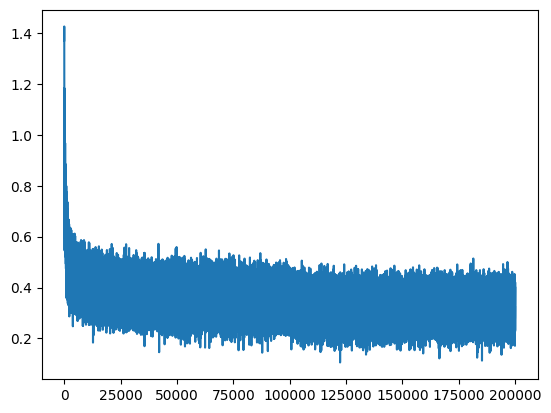

In [14]:
params = model(words, embedding_size = 10, context_length = 3, num_iterations = 200_000, diagnose = True)

Predicting

In [15]:
sample(params, 3)

moha.
kmyah.
see.
med.
rylla.
emmastendraeg.
adelyn.
eliah.
milopi.
eden.
van.
aaraelyn.
malaia.
noshubnrgshiries.
kindreelynn.
nophirous.
kynder.
yaruemela.
kayjahshella.
hil.
